In [1]:
import tensorflow.compat.v1 as tf
import numpy as np
import matplotlib.pyplot as plt
import warnings
import math
import sys
import logging
#-----------------------------------------------------------
from tensorflow.python.ops import control_flow_ops
from IPython.display import clear_output
from scipy.spatial.distance import squareform, pdist
from sklearn.preprocessing import normalize
from numpy import linalg as LA
from scipy.cluster.vq import kmeans, vq
from sklearn.metrics import normalized_mutual_info_score
from math import sqrt
#----------------------------------------------

from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from optparse import OptionParser
from tqdm import tqdm

In [2]:
def standardization(X):
    return normalize(X, axis=0)

In [3]:
def laplacian(A):
    S = np.sum(A, 0)
    D = np.diag(S)
    D = LA.matrix_power(D, -1)
    L = np.dot(D, A)
    return L

In [4]:
def normalization(V):
    return (V - min(V)) / (max(V) - min(V))

In [5]:
class Correlation_Similarity:
    def get_matrix(self, Data):
        X = standardization(Data)
        X = pdist(X, 'correlation')
        X = squareform(X)
        L = laplacian(X)
        Y = np.apply_along_axis(normalization, 1, L)
        return Y

In [6]:
class Cosine_Similarity:
    def get_matrix(self, Data):
        X = standardization(Data)
        X = pdist(X, 'cosine')
        X = squareform(X)
        L = laplacian(X)
        Y = np.apply_along_axis(normalization, 1, L)
        return Y

In [7]:
class Similarity_Dataset_Iterator():
    def __init__(self, data, labels, similarity):
        self.data = data
        self.labels = labels
        self.matrix = similarity.get_matrix(data)
        self.data_size = self.matrix.shape[0]
        self.current_index = 0
    def next_batch(self, num):
        data=self.matrix.transpose()
        labels=self.labels
        idx = np.arange(0 , len(data))
        np.random.shuffle(idx)
        idx = idx[:num]
        data_shuffle = [data[ i] for i in idx]
        labels_shuffle = [labels[ i] for i in idx]
        return data_shuffle, labels_shuffle
    def whole_dataset(self):
        return (self.matrix.transpose(), self.labels)

In [9]:
from google.colab import drive

#drive.mount('/content/drive')

In [10]:
import pandas as pd
df = pd.read_csv('/content/drive/My Drive/edited_topics_set2.csv')
df.head()

,Unnamed: 0,Unnamed: 0.1,_id,topic,content,processed_content,processed_topic
0,0,0,5f04e496ef217aae6a201f71,"[""National""]","[""The West Bengal government on Tuesday decide...",west bengal govern tuesday decid impos complet...,nation
1,1,1,5f04e498ef217aae6a201f72,"[""Business""]","[""The government is weighing the pros and cons...",govern weigh pros con halt import includ china...,busi
2,2,2,5f04e49aef217aae6a201f73,"[""National""]","[""The Central Board of Secondary Education (CB...",central board secondari educ cbse slash syllab...,nation
3,3,3,5f04e49def217aae6a201f74,"[""International""]","[""The World Health Organization on Tuesday ack...",world health organ tuesday acknowledg emerg ev...,intern
4,4,4,5f04e49fef217aae6a201f75,"[""International""]","[""President Donald Trump on Tuesday formally s...",presid donald trump tuesday formal start withd...,intern


In [13]:
df.drop(['Unnamed: 0', 'Unnamed: 0.1'], axis=1)

,_id,topic,content,processed_content,processed_topic
0,5f04e496ef217aae6a201f71,"[""National""]","[""The West Bengal government on Tuesday decide...",west bengal govern tuesday decid impos complet...,nation
1,5f04e498ef217aae6a201f72,"[""Business""]","[""The government is weighing the pros and cons...",govern weigh pros con halt import includ china...,busi
2,5f04e49aef217aae6a201f73,"[""National""]","[""The Central Board of Secondary Education (CB...",central board secondari educ cbse slash syllab...,nation
3,5f04e49def217aae6a201f74,"[""International""]","[""The World Health Organization on Tuesday ack...",world health organ tuesday acknowledg emerg ev...,intern
4,5f04e49fef217aae6a201f75,"[""International""]","[""President Donald Trump on Tuesday formally s...",presid donald trump tuesday formal start withd...,intern
...,...,...,...,...,...
2150,5f04c5bd2ba198f21c82c4b2,"[""Business""]","[""Ride-hailing platform Ola on Tuesday announc...",ride hail platform tuesday announc enter strat...,busi
2151,5f04c5c02ba198f21c82c4b3,"[""Coronavirus""]","[""Delhi Chief Minister Arvind Kejriwal on Mond...",delhi chief minist arvind kejriw monday appeal...,coronavirus
2152,5f04c5c22ba198f21c82c4b4,"[""Cities""]","[""Tibetan spiritual leader Dalai Lama on Monda...",tibetan spiritu leader dalai lama monday celeb...,citi
2153,5f04c5c42ba198f21c82c4b5,"[""Business""]","[""Infosys has brought back a little more than ...",infosi bring littl peopl primarili includ comp...,busi


In [11]:
#df.dropna(subset=['content'], inplace = True)
df.dropna(subset=['processed_topic'], inplace = True)
#df['your column name'].isnull().values.any()

In [ ]:
#len(df.content.unique()),  len(df.content), len(df.topic)

(1204, 1304, 1304)

In [14]:
df.isnull().sum()

Unnamed: 0           0
Unnamed: 0.1         0
_id                  0
topic                0
content              0
processed_content    0
processed_topic      0
dtype: int64

In [15]:
df.shape

(2155, 7)

In [16]:
np.unique(df.processed_topic[:600]).shape[0]

20

In [ ]:
#import re

#import gensim
#from gensim import corpora,models
#from gensim.utils import simple_preprocess
#from gensim.models import CoherenceModel
#from gensim.parsing.preprocessing import STOPWORDS
#from nltk.stem import WordNetLemmatizer, SnowballStemmer
#from nltk.stem.porter import *
#import numpy as np
#np.random.seed(2018)

#import nltk
#nltk.download('wordnet')
#nltk.download('stopwords')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
#stemmer = SnowballStemmer(language='english',ignore_stopwords=True)
#def lemmatize_stemming(text):
#    return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos='v'))
#def preprocess(text):
    #result = []
   # for token in gensim.utils.simple_preprocess(text):
   #     if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
   #         result.append(lemmatize_stemming(token))
  #  return result

In [ ]:
#doc_sample = df['content'][0]
#print('original document: ')
#words = []
#for word in doc_sample.split(' '):
#    words.append(word)
#print(words)
#print('\n\n tokenized and lemmatized document: ')
#print(preprocess(doc_sample))

original document: 
['["Garbage-lined', 'streets', 'and', 'overflowing', 'drains', 'across', 'Salt', 'Lake', 'have', 'sparked', 'fear', 'of', 'an', 'outbreak', 'of', 'enteric', 'diseases', 'and', 'are', 'forcing', 'residents', 'to', 'keep', 'the', 'windows', 'and', 'doors', 'of', 'their', 'houses', 'firmly', 'shut.","Residents', 'said', 'most', 'of', 'the', '150', 'tonnes', 'of', 'the', 'garbage', 'Salt', 'Lake', 'generates', 'every', 'day', 'is', 'accumulating', 'across', 'the', '33.5sq', 'km', 'township.","“At', 'this', 'rate,', 'Salt', 'Lake', 'will', 'soon', 'become', 'Dhapa.', 'This', 'is', 'happening', 'at', 'a', 'time', 'the', 'authorities', 'as', 'well', 'as', 'residents', 'need', 'to', 'focus', 'on', 'hygiene', 'to', 'combat', 'Covid', 'and', 'dengue,”', 'said', 'a', 'resident,', 'hand', 'firmly', 'on', 'his', 'nose.","“It', 'is', 'true', 'that', 'garbage', 'has', 'accumulated', 'in', 'some', 'places', 'but', 'I', 'don’t', 'think', 'it', 'is', 'a', 'big', 'problem.', 'We', 'wi

In [ ]:
#df['processed_heading'] = df['heading'].map(preprocess)
#df['processed_content'] = df['content'].map(preprocess)
#df['processed_topic'] = df['topic'].map(preprocess)
#df['processed_heading'] = df['processed_heading'].apply(lambda x: ' '.join(x))
#df['processed_content'] = df['processed_content'].apply(lambda x: ' '.join(x))
#df['processed_topic'] = df['processed_topic'].apply(lambda x: ' '.join(x))
#df.head()

,_id,topic,heading,content,tags,processed_content,processed_topic
0,5f04d2481f35ed6864839349,"[""West-bengal""]","[""\n "",""\n ...","[""Garbage-lined streets and overflowing drains...","[""Garbage"",""Salt-lake"",""Bidhannagar-municipal-...",garbag line street overflow drain salt lake sp...,west bengal
1,5f04d24b1f35ed686483934a,"[""West-bengal""]","[""\n "",""\n ...","[""The Bengal government will set up a plasma b...","[""Calcutta-medical-college-and-hospital"",""Coro...",bengal govern plasma bank calcutta medic colle...,west bengal
2,5f04d24d1f35ed686483934b,"[""West-bengal""]","[""\n "",""\n ...","[""Bengal set another 24-hour record on Monday ...","[""Lockdown"",""Coronavirus"",""Quarantine""]",bengal hour record monday highest number covid...,west bengal
3,5f04d2501f35ed686483934c,"[""West-bengal""]","[""\n "",""\n ...","[""Chief minister Mamata Banerjee on Monday sai...","[""Mamata-banerjee"",""Cyclone-amphan""]",chief minist mamata banerje monday say problem...,west bengal
4,5f04d2531f35ed686483934d,"[""West-bengal""]","[""\n "",""\n ...","[""Some senior historians have raised questions...","[""Jagat-prakash-nadda"",""Bharatiya-janata-party...",senior historian rais question attempt pitch b...,west bengal


In [ ]:
df.to_csv('/content/drive/My Drive/edited_all_news.csv')

In [ ]:
#from collections import Counter
#Counter(df.topic[700:])

In [17]:
def read_NewsGroup_data(similarity):    
    logging.basicConfig(level=logging.INFO,
                        format='%(asctime)s %(levelname)s %(message)s')
    op = OptionParser()
    op.add_option("--lsa", dest="n_components", type="int",
                  help="Preprocess documents with latent semantic analysis.")    
    op.add_option("--no-idf",action="store_false", dest="use_idf", default=True,
                  help="Disable Inverse Document Frequency feature weighting.")
    op.add_option("--use-hashing", action="store_true", default=False,
                  help="Use a hashing feature vectorizer")
    op.add_option("--n-features", type=int, default=10000,
                  help="Maximum number of features to extract from text.")    
    def is_interactive():
        return not hasattr(sys.modules['__main__'], '__file__')
    argv = [] if is_interactive() else sys.argv[1:]
    (opts, args) = op.parse_args(argv)
    if len(args) > 0:
        op.error("this script takes no arguments.")
        sys.exit(1)
        
    labels = df.processed_topic
    data = df.processed_content
        #true_k = np.unique(labels).shape[0]
    vectorizer = TfidfVectorizer(max_features=opts.n_features,use_idf=opts.use_idf)
    X = vectorizer.fit_transform(data)
    if opts.n_components:
        svd = TruncatedSVD(opts.n_components)
        normalizer = Normalizer(copy=False)
        lsa = make_pipeline(svd, normalizer)
        X = lsa.fit_transform(X)
        explained_variance = svd.explained_variance_ratio_.sum()
    return Similarity_Dataset_Iterator(X.toarray(), labels, similarity)

In [18]:
# Call Correlation_Similarity as similarity dataset.
trainSet_correlation = read_NewsGroup_data(Correlation_Similarity())

In [19]:
# Call Cosine_Similarity as similarity dataset.
trainSet_cosine = read_NewsGroup_data(Cosine_Similarity())

In [20]:
n_input = trainSet_correlation.data_size #--------- Number of input data.
print(n_input)
# Define the number of hidden layer. 
if n_input >= 1024:
    Nn = int(2048)
elif n_input >= 512:
    Nn = int(1024)
elif n_input >= 256:
    Nn = int(512)

2155


In [21]:
n_hidden_1 = int(Nn/2) #-------------------- The autoencoder hidden layer 1.
n_code = str(int(n_hidden_1/2)) #----------- The number of output dimension value.

In [22]:
print('Layer 1: -----------', n_input)
print('Layer 2: -----------', n_hidden_1)
print('Layer 3: -----------', int(n_code))

Layer 1: ----------- 2155
Layer 2: ----------- 1024
Layer 3: ----------- 512


In [23]:
def k_means_(X, n_clusters):
    kmeans_centroids,_ =  kmeans(X, n_clusters)
    kmeans_, _ = vq(X, kmeans_centroids)
    return kmeans_

In [24]:
def encoder(x, n_code, mode_train):    
    with tf.variable_scope("encoder"):        
        with tf.variable_scope("hidden-layer-1"):
            hidden_1 = layer(x, [n_input, n_hidden_1], [n_hidden_1], mode_train)
        with tf.variable_scope("embedded"):
            code = layer(hidden_1, [n_hidden_1, n_code], [n_code], mode_train)
    return code

In [25]:
def decoder(code, n_code, mode_train):
    with tf.variable_scope("decoder"):
        with tf.variable_scope("hidden-layer-1"):
            hidden_1 = layer(code, [n_code, n_hidden_1], [n_hidden_1], mode_train)
        with tf.variable_scope("reconstructed"):
            output = layer(hidden_1, [n_hidden_1, n_input], [n_input], mode_train)
    return output

In [26]:
def batch_norm(x, n_out, mode_train):
    beta_initialize = tf.constant_initializer(value=0.1, dtype=tf.float32)
    gamma_initialize = tf.constant_initializer(value=0.1, dtype=tf.float32)
    beta = tf.get_variable("beta", [n_out], initializer=beta_initialize)
    gamma = tf.get_variable("gamma", [n_out], initializer=gamma_initialize)
    batch_mean, batch_var = tf.nn.moments(x, [0], name='moments')
    ema = tf.train.ExponentialMovingAverage(decay=0.9)
    ema_apply_op = ema.apply([batch_mean, batch_var])
    ema_mean, ema_var = ema.average(batch_mean), ema.average(batch_var)
    def mean_var():
        with tf.control_dependencies([ema_apply_op]):
            return tf.identity(batch_mean), tf.identity(batch_var)
    mean, var = control_flow_ops.cond(mode_train, mean_var, lambda: (ema_mean, ema_var))
    reshaped_x = tf.reshape(x, [-1, 1, 1, n_out])
    normed = tf.nn.batch_norm_with_global_normalization(reshaped_x, mean, var, beta, gamma, 1e-08, True)
    return tf.reshape(normed, [-1, n_out])

In [27]:
def layer(input, weight_shape, bias_shape, mode_train):
    value_initialize = (1.0 / weight_shape[0] ** 0.5)
    weight_initialize = tf.random_normal_initializer(stddev = value_initialize, seed = None)
    bias_initialize = tf.constant_initializer(value=0.0, dtype=tf.float32)
    w = tf.get_variable("w", weight_shape, initializer=weight_initialize)
    b = tf.get_variable("b", bias_shape, initializer=bias_initialize)
    return tf.nn.sigmoid(batch_norm((tf.matmul(input, w) + b), weight_shape[1], mode_train))

In [28]:
def loss(reconstructed, x):
    with tf.variable_scope("train"):
        train_loss = tf.reduce_mean(tf.reduce_sum(tf.square(tf.subtract(reconstructed, x)), 1))
        return train_loss

In [29]:
def training(cost, learning_rate, beta1, beta2, global_step):
    optimizer = tf.train.AdamOptimizer(learning_rate, beta1, beta2, epsilon=1e-08, use_locking=False, name='Adam')
    train_op = optimizer.minimize(cost, global_step=global_step)
    return train_op

In [34]:
# Parameters
n_layers = 3 #------------------------------ Number of Neural Networks Layers.
beta1 = 0.9 #------------------------------- The decay rate 1.  
beta2 = 0.999 #----------------------------- The decay rate 2.
learning_rate = (beta1/n_input) #----------- The learning rate.
#n_batch = math.ceil(sqrt(sqrt(n_input))) #-- Number of selection data in per step.
n_batch = 32
n_backpro = math.ceil(n_input/n_batch) #---- Number of Backpro in per epoch.
n_clusters = 20 #---------------------------- Number of clusters.

print(n_batch)

32


In [35]:
data_cor, labels_cor = trainSet_correlation.whole_dataset() #-- Allocation of data and labels
data_cos, labels_cos = trainSet_cosine.whole_dataset() #------- Allocation of data and labels

In [36]:
results_cor=[] #--------------------------- A list to keep all NMI scores.
loss_cost_cor=[] #------------------------- A list to keep all training evaluations.
seeding_cor=[] #--------------------------- A list to keep all steps.

In [37]:
for i in range(1, 11):
    with tf.Graph().as_default():    
        with tf.variable_scope("autoencoder_architecture"):
            x = tf.placeholder("float", [None, n_input])   
            mode_train = tf.placeholder(tf.bool)
            code = encoder(x, int(n_code), mode_train)
            reconstructed = decoder(code, int(n_code), mode_train)
            cost = loss(reconstructed, x)
            global_step = tf.Variable(0, name='global_step', trainable=False)
            train_optimizer = training(cost, learning_rate, beta1, beta2, global_step)
            sess = tf.Session()
            init_op = tf.global_variables_initializer()
            sess.run(init_op)
            # Training cycle
            for ii in range(n_layers):
                # Fit training with backpropagation using batch data.
                for jj in range(n_backpro):
                    miniData, _ = trainSet_correlation.next_batch(n_batch)
                    _, new_cost = sess.run([train_optimizer,cost], feed_dict={x: miniData,
                                                                              mode_train: True})       
                #------------------------- End of the Optimization ------------------------------
                
    # Getting embedded codes and running K-Means on them.
    ae_codes_cor = sess.run(code, feed_dict={x: data_cor, mode_train: False})        
    idx_cor = k_means_(ae_codes_cor, n_clusters)
    ae_nmi_cor = normalized_mutual_info_score(labels_cor, idx_cor)
    ae_nmi_cor = ae_nmi_cor*100
    results_cor.append(ae_nmi_cor)    
    seeding_cor.append(i)
    loss_cost_cor.append(new_cost)    
    print("NMI score for AE is: {:0.2f} and new cost is: {:0.2f} in {:d} step of seeding."
          .format(ae_nmi_cor, new_cost, i))

NMI score for AE is: 37.68 and new cost is: 422.54 in 1 step of seeding.
NMI score for AE is: 37.51 and new cost is: 420.15 in 2 step of seeding.
NMI score for AE is: 36.51 and new cost is: 421.10 in 3 step of seeding.
NMI score for AE is: 37.32 and new cost is: 421.14 in 4 step of seeding.
NMI score for AE is: 35.62 and new cost is: 421.02 in 5 step of seeding.
NMI score for AE is: 36.51 and new cost is: 422.43 in 6 step of seeding.
NMI score for AE is: 36.77 and new cost is: 421.51 in 7 step of seeding.
NMI score for AE is: 38.98 and new cost is: 420.52 in 8 step of seeding.
NMI score for AE is: 37.65 and new cost is: 421.19 in 9 step of seeding.
NMI score for AE is: 37.62 and new cost is: 422.22 in 10 step of seeding.


In [38]:
print("The Average of NMI Score for >>> {:d} <<< Random Factors in Autoencoder Correlation is >>> {:0.2f} <<<"
      .format(len(seeding_cor), (np.mean(results_cor))))

The Average of NMI Score for >>> 10 <<< Random Factors in Autoencoder Correlation is >>> 37.22 <<<


In [39]:
results_cor

[37.68267198140483,
 37.513186163571646,
 36.506454161644456,
 37.31853951214437,
 35.620455271752775,
 36.509509537851734,
 36.77475349357957,
 38.98128846698066,
 37.654179927192985,
 37.620620540399315]

In [40]:
results_cos=[] #--------------------------- A list to keep all NMI scores.
loss_cost_cos=[] #------------------------- A list to keep all training evaluations.
seeding_cos=[] #--------------------------- A list to keep all steps.

In [41]:
for i in range(1, 11):
    with tf.Graph().as_default():    
        with tf.variable_scope("autoencoder_architecture"):
            x = tf.placeholder("float", [None, n_input])   
            mode_train = tf.placeholder(tf.bool)
            code = encoder(x, int(n_code), mode_train)
            reconstructed = decoder(code, int(n_code), mode_train)
            cost = loss(reconstructed, x)
            global_step = tf.Variable(0, name='global_step', trainable=False)
            train_optimizer = training(cost, learning_rate, beta1, beta2, global_step)
            sess = tf.Session()
            init_op = tf.global_variables_initializer()
            sess.run(init_op)
            # Training cycle
            for ii in range(n_layers):
                # Fit training with backpropagation using batch data.
                for jj in range(n_backpro):
                    miniData, _ = trainSet_cosine.next_batch(n_batch)
                    _, new_cost = sess.run([train_optimizer,cost], feed_dict={x: miniData,
                                                                              mode_train: True})       
                #------------------------- End of the Optimization ------------------------------

    # Getting embedded codes and running K-Means on them.
    ae_codes_cos = sess.run(code, feed_dict={x: data_cos, mode_train: False})        
    idx_cos = k_means_(ae_codes_cos, n_clusters)
    ae_nmi_cos = normalized_mutual_info_score(labels_cos, idx_cos)
    ae_nmi_cos = ae_nmi_cos*100
    results_cos.append(ae_nmi_cos)    
    seeding_cos.append(i)
    loss_cost_cos.append(new_cost)    
    print("NMI score for AE is: {:0.2f} and new cost is: {:0.2f} in {:d} step of seeding."
          .format(ae_nmi_cos, new_cost, i))

NMI score for AE is: 34.60 and new cost is: 426.64 in 1 step of seeding.
NMI score for AE is: 35.53 and new cost is: 424.53 in 2 step of seeding.
NMI score for AE is: 37.36 and new cost is: 424.68 in 3 step of seeding.
NMI score for AE is: 36.78 and new cost is: 426.82 in 4 step of seeding.
NMI score for AE is: 36.29 and new cost is: 424.57 in 5 step of seeding.
NMI score for AE is: 35.38 and new cost is: 424.83 in 6 step of seeding.
NMI score for AE is: 38.41 and new cost is: 426.83 in 7 step of seeding.
NMI score for AE is: 38.16 and new cost is: 425.14 in 8 step of seeding.
NMI score for AE is: 39.37 and new cost is: 426.41 in 9 step of seeding.
NMI score for AE is: 38.56 and new cost is: 424.41 in 10 step of seeding.


In [42]:
print("The Average of NMI Score for >>> {:d} <<< Random Factors in Autoencoder Cosine is >>> {:0.2f} <<<"
      .format(len(seeding_cos), (np.mean(results_cos))))

The Average of NMI Score for >>> 10 <<< Random Factors in Autoencoder Cosine is >>> 37.04 <<<


In [43]:
results_cos

[34.600464951696985,
 35.53200700308353,
 37.36117612917431,
 36.77599636756918,
 36.28834205297791,
 35.37993052038826,
 38.40736878877157,
 38.16090629093182,
 39.36749434228251,
 38.558287418052664]

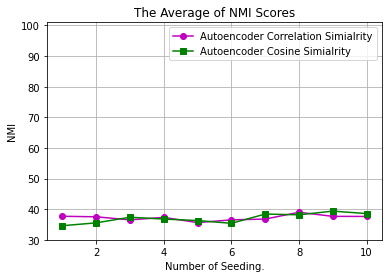

In [44]:
warnings.filterwarnings('ignore')
plt.ylim(30,101)
plt.plot(seeding_cor, results_cor, label='Autoencoder Correlation Simialrity', color='m', marker='o')
plt.plot(seeding_cos, results_cos, label='Autoencoder Cosine Simialrity', color='g', marker='s')
plt.xlabel('Number of Seeding.')
plt.ylabel('NMI')
plt.grid()
plt.title('The Average of NMI Scores')
plt.legend(loc='best')
plt.show()

In [45]:
print("Autoencoder Clustering on Cosine: ------------ {:0.2f}".format(np.mean(results_cos)))
print("Autoencoder Clustering on Correlation: ------- {:0.2f}".format(np.mean(results_cor)))

Autoencoder Clustering on Cosine: ------------ 37.04
Autoencoder Clustering on Correlation: ------- 37.22


In [46]:
#feature extraction
vec = TfidfVectorizer(stop_words="english")
vec.fit(df.processed_content.values)
features = vec.transform(df.processed_content.values)

In [47]:
# function to print out classification model report
def classification_report(model_name, test, pred):
    from sklearn.metrics import precision_score, recall_score
    from sklearn.metrics import accuracy_score
    from sklearn.metrics import f1_score
    
    print(model_name, ":\n")
    print("Accuracy Score: ", '{:,.3f}'.format(float(accuracy_score(test, pred)) * 100), "%")
    print("     Precision: ", '{:,.3f}'.format(float(precision_score(test, pred, average='macro')) * 100), "%")
    print("        Recall: ", '{:,.3f}'.format(float(recall_score(test, pred, average='macro')) * 100), "%")
    print("      F1 score: ", '{:,.3f}'.format(float(f1_score(test, pred, average='macro')) * 100), "%")
    
#Let's split the data into train/test sets

from sklearn.model_selection import train_test_split

# test set size of 20% of the data and the random seed 42 <3
X_train, X_test, y_train, y_test = train_test_split(features.toarray(),idx_cor, test_size=0.2, random_state=42)

print("X_train size:", len(X_train))
print("X_test size:", len(X_test), "\n")

X_train size: 1724
X_test size: 431 



In [48]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.linear_model import SGDClassifier

# SGD instance
sgd_clf = SGDClassifier(max_iter=10000, tol=1e-3, random_state=42, n_jobs=4)
# train SGD
sgd_clf.fit(X_train, y_train)

# cross validation predictions
sgd_pred = cross_val_predict(sgd_clf, X_train, y_train, cv=3, n_jobs=4)

# print out the classification report
classification_report("Stochastic Gradient Descent Report (Training Set)", y_train, sgd_pred)

Stochastic Gradient Descent Report (Training Set) :

Accuracy Score:  81.961 %
     Precision:  87.106 %
        Recall:  83.483 %
      F1 score:  84.651 %


In [49]:
# cross validation predictions
sgd_pred = cross_val_predict(sgd_clf, X_test, y_test, cv=3, n_jobs=4)

# print out the classification report
classification_report("Stochastic Gradient Descent Report (Training Set)", y_test, sgd_pred)

Stochastic Gradient Descent Report (Training Set) :

Accuracy Score:  72.158 %
     Precision:  76.115 %
        Recall:  71.924 %
      F1 score:  72.476 %


In [51]:
sgd_cv_score = cross_val_score(sgd_clf, features.toarray(), idx_cor, cv=10)
print("Mean cv Score - SGD: {:,.3f}".format(float(sgd_cv_score.mean()) * 100), "%")

Mean cv Score - SGD: 82.691 %


In [52]:
# function to print out classification model report
def classification_report(model_name, test, pred):
    from sklearn.metrics import precision_score, recall_score
    from sklearn.metrics import accuracy_score
    from sklearn.metrics import f1_score
    
    print(model_name, ":\n")
    print("Accuracy Score: ", '{:,.3f}'.format(float(accuracy_score(test, pred)) * 100), "%")
    print("     Precision: ", '{:,.3f}'.format(float(precision_score(test, pred, average='macro')) * 100), "%")
    print("        Recall: ", '{:,.3f}'.format(float(recall_score(test, pred, average='macro')) * 100), "%")
    print("      F1 score: ", '{:,.3f}'.format(float(f1_score(test, pred, average='macro')) * 100), "%")
    
#Let's split the data into train/test sets

from sklearn.model_selection import train_test_split

# test set size of 20% of the data and the random seed 42 <3
X_train, X_test, y_train, y_test = train_test_split(features.toarray(),idx_cos, test_size=0.2, random_state=42)

print("X_train size:", len(X_train))
print("X_test size:", len(X_test), "\n")

X_train size: 1724
X_test size: 431 



In [53]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.linear_model import SGDClassifier

# SGD instance
sgd_clf = SGDClassifier(max_iter=10000, tol=1e-3, random_state=42, n_jobs=4)
# train SGD
sgd_clf.fit(X_train, y_train)

# cross validation predictions
sgd_pred = cross_val_predict(sgd_clf, X_train, y_train, cv=3, n_jobs=4)

# print out the classification report
classification_report("Stochastic Gradient Descent Report (Training Set)", y_train, sgd_pred)

Stochastic Gradient Descent Report (Training Set) :

Accuracy Score:  84.397 %
     Precision:  88.455 %
        Recall:  88.385 %
      F1 score:  88.186 %


In [54]:
# cross validation predictions
sgd_pred = cross_val_predict(sgd_clf, X_test, y_test, cv=3, n_jobs=4)

# print out the classification report
classification_report("Stochastic Gradient Descent Report (Training Set)", y_test, sgd_pred)

Stochastic Gradient Descent Report (Training Set) :

Accuracy Score:  72.854 %
     Precision:  80.672 %
        Recall:  73.825 %
      F1 score:  75.214 %


In [ ]:
sgd_cv_score = cross_val_score(sgd_clf, features.toarray(), idx_cor, cv=10)
print("Mean cv Score - SGD: {:,.3f}".format(float(sgd_cv_score.mean()) * 100), "%")

Mean cv Score - SGD: 82.691 %
